## Data and Libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy
import random

# set the PseudoRandom Generator Seeds for better reproducibility
# see here for more: https://pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(99)
random.seed(99)
numpy.random.seed(99)

# this 'device' will be used for training our model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### **Load the MNIST dataset**
Observe that we set `shuffle=True`, which means that data is randomized

In [3]:
input_size  = 28*56   # images are 28x56 pixels
output_size = 100      # there are 100 classes

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=10, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=10, shuffle=True)
classNames = [i for i in range(100)]

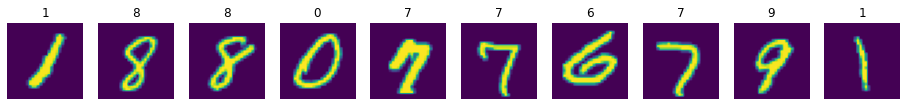

In [4]:
# show some training images
def imshow(img, plot):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.squeeze().numpy()   # convert from tensor
    plot.imshow(npimg) 
    
# show some training images
plt.figure(figsize=(16, 4))

# fetch a batch of train images; RANDOM
image_batch, label_batch = next(iter(train_loader))

for i in range(10):
    image = image_batch[i]
    label = label_batch[i].item()
    plt.subplot(1, 10, i + 1)
    # image, label = train_loader.dataset.__getitem__(i)
    # plt.imshow(image.squeeze().numpy())
    imshow(image,plt)
    plt.axis('off')
    plt.title(classNames[label])

#Preparing the training and test set for 2-digit images

In [5]:
data = []
target = []

for i,j in enumerate(train_loader):
  tmp_data = []
  tmp_target = []
  for k in range(10):
    for l in range(10):
      tmp_data.append((torch.cat((j[0][k],j[0][l]),-1)))
      tmp_target.append((10*j[1][k]+j[1][l]))
  data.append(tmp_data)
  target.append(tmp_target)

test_data = []
test_target = []

for i,j in enumerate(test_loader):
  tmp_data = []
  tmp_target = []
  for k in range(10):
    for l in range(10):
      tmp_data.append((torch.cat((j[0][k],j[0][l]),-1)))
      tmp_target.append((10*j[1][k]+j[1][l]))
  test_data.append(tmp_data)
  test_target.append(tmp_target)

In [5]:
len(test_data),len(test_target)

(1000, 1000)

In [6]:
len(data[0])

100

In [6]:
Train_data = []
for i in range(len(data)):
  Train_data.append((data[i],target[i]))

In [7]:
Test_data = []
for i in range(len(test_data)):
  Test_data.append((test_data[i],test_target[i]))

In [9]:
len(Train_data)

6000

In [10]:
len(Train_data[0][0])

100

In [11]:
Train_data[0][0][0].shape

torch.Size([1, 28, 56])

In [8]:
for index, (i,j) in enumerate(Train_data):
  Train_data[index] = (torch.stack(i),torch.stack(j))

In [9]:
for index, (i,j) in enumerate(Test_data):
  Test_data[index] = (torch.stack(i),torch.stack(j))

In [14]:
len(train_loader)

6000

In [15]:
len(Train_data*len(Train_data[0][0]))

600000

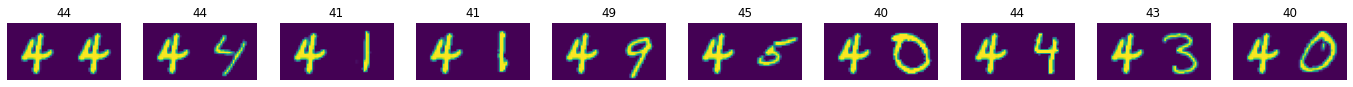

In [16]:
# show some training images
def imshow(img, plot):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.squeeze().numpy()   # convert from tensor
    plot.imshow(npimg) 
    
# show some training images
plt.figure(figsize=(24, 6))

# fetch a batch of train images; RANDOM
image_batch, label_batch = next(iter(Train_data))

for i in range(10):
    image = image_batch[i]
    label = label_batch[i].item()
    plt.subplot(1, 10, i + 1)
    # image, label = train_loader.dataset.__getitem__(i)
    # plt.imshow(image.squeeze().numpy())
    imshow(image,plt)
    plt.axis('off')
    plt.title(classNames[label])

## A 3-hidden layer Fully Connected Neural Network


### Helper functions for training and testing

In [10]:
# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

accuracy_list = []
# we pass a model object to this trainer, and it trains this model for one epoch
def train(epoch, model):
    model.train()
    for batch_idx, (data, target) in enumerate(Train_data):
        # send to device
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(Train_data*len(Train_data[0][0])),
                100. * batch_idx / len(Train_data), loss.item()))
            
def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(Test_data):
        # send to device
        data, target = data.to(device), target.to(device)
        
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(Test_data*len(Test_data[0][0]))
    accuracy = 100. * correct / len(Test_data*len(Test_data[0][0]))
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(Test_data*len(Test_data[0][0])),
        accuracy))
    return correct

### Defining the Fully Connected Network

In [18]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, 400), 
            nn.ReLU(), 
            nn.Linear(400,400),
            nn.ReLU(),
            nn.Linear(400,300), 
            nn.ReLU(), 
            nn.Linear(300, output_size), 
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)

### Train the Network

In [20]:
print("Training on ", device)
model_fnn = FC2Layer(input_size, output_size)
model_fnn.to(device)
lr = 0.1
optimizer = optim.SGD(model_fnn.parameters(), lr=lr)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

hits = 0
epoch = 0
acc_init = 0

while hits < 5:
  train(epoch, model_fnn)
  epoch += 1
  acc = test(model_fnn)
  if acc < acc_init:
    hits += 1
    print("hit patience ",hits)
    print("hit #",hits," trial")
    print("load previously best model and decay learning rate to ",lr/2)
    lr = lr/2
    optimizer = optim.SGD(model_fnn.parameters(), lr=lr)
    train(epoch, model_fnn)
    epoch += 1
    acc = test(model_fnn)
  acc_init = acc

Training on  cuda:0
Number of parameters: 938400
Train Epoch: 0 [0/600000 (0%)]	Loss: 4.620193
Train Epoch: 0 [10000/600000 (2%)]	Loss: 3.825286
Train Epoch: 0 [20000/600000 (3%)]	Loss: 2.465340
Train Epoch: 0 [30000/600000 (5%)]	Loss: 0.903995
Train Epoch: 0 [40000/600000 (7%)]	Loss: 0.959472
Train Epoch: 0 [50000/600000 (8%)]	Loss: 0.824965
Train Epoch: 0 [60000/600000 (10%)]	Loss: 1.357056
Train Epoch: 0 [70000/600000 (12%)]	Loss: 1.654762
Train Epoch: 0 [80000/600000 (13%)]	Loss: 0.621609
Train Epoch: 0 [90000/600000 (15%)]	Loss: 0.430388
Train Epoch: 0 [100000/600000 (17%)]	Loss: 0.587443
Train Epoch: 0 [110000/600000 (18%)]	Loss: 0.272085
Train Epoch: 0 [120000/600000 (20%)]	Loss: 0.189940
Train Epoch: 0 [130000/600000 (22%)]	Loss: 0.592879
Train Epoch: 0 [140000/600000 (23%)]	Loss: 0.456415
Train Epoch: 0 [150000/600000 (25%)]	Loss: 0.869145
Train Epoch: 0 [160000/600000 (27%)]	Loss: 1.836917
Train Epoch: 0 [170000/600000 (28%)]	Loss: 0.681294
Train Epoch: 0 [180000/600000 (30%)

### Show some predictions of the test network

In [11]:
def visualize_pred(img, pred_prob, real_label):
    ''' Function for viewing an image and it's predicted classes.
    '''
    #pred_prob = pred_prob.data.squeeze().numpy()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,24), ncols=2)
    ax1.imshow(img.squeeze().numpy())
    imshow(img, ax1)
    ax1.axis('off')
    pred_label = numpy.argmax(pred_prob)
    ax1.set_title([classNames[real_label], classNames[pred_label]])
    
    ax2.barh(numpy.arange(100), pred_prob)
    ax2.set_aspect(0.1)
    ax2.set_yticks(numpy.arange(100))
    ax2.set_yticklabels(numpy.arange(100))
    ax2.set_ylim(0,100)
    ax2.set_title('Prediction Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()



In [22]:
image_batch, label_batch = next(iter(Test_data))
print(label_batch)

tensor([11, 12, 19, 19, 11, 12, 19, 11, 11, 19, 21, 22, 29, 29, 21, 22, 29, 21,
        21, 29, 91, 92, 99, 99, 91, 92, 99, 91, 91, 99, 91, 92, 99, 99, 91, 92,
        99, 91, 91, 99, 11, 12, 19, 19, 11, 12, 19, 11, 11, 19, 21, 22, 29, 29,
        21, 22, 29, 21, 21, 29, 91, 92, 99, 99, 91, 92, 99, 91, 91, 99, 11, 12,
        19, 19, 11, 12, 19, 11, 11, 19, 11, 12, 19, 19, 11, 12, 19, 11, 11, 19,
        91, 92, 99, 99, 91, 92, 99, 91, 91, 99])


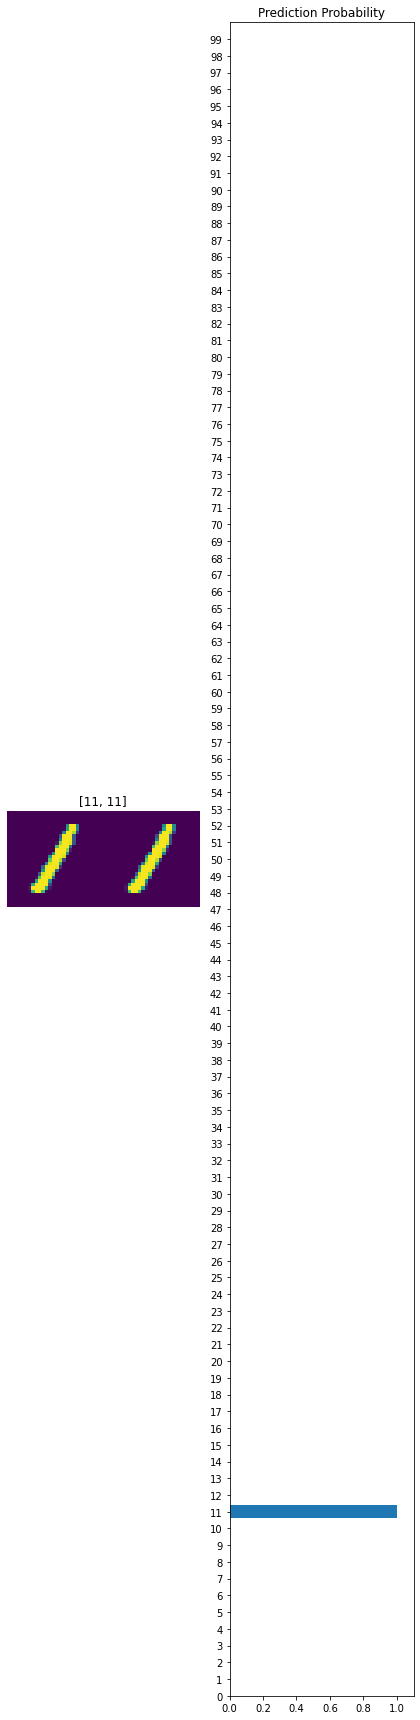

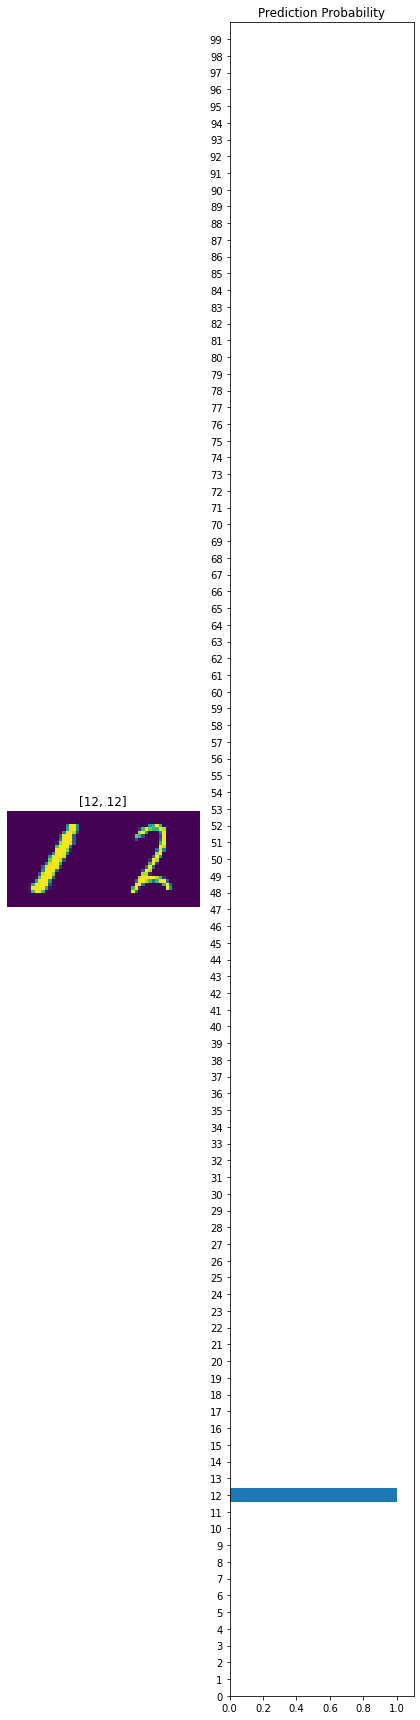

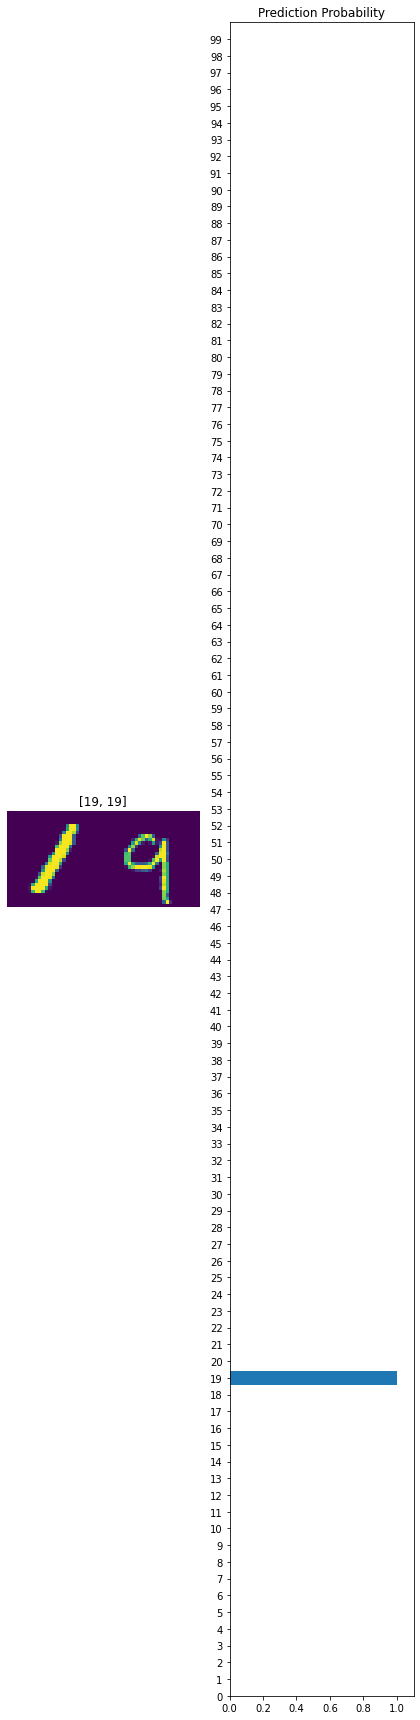

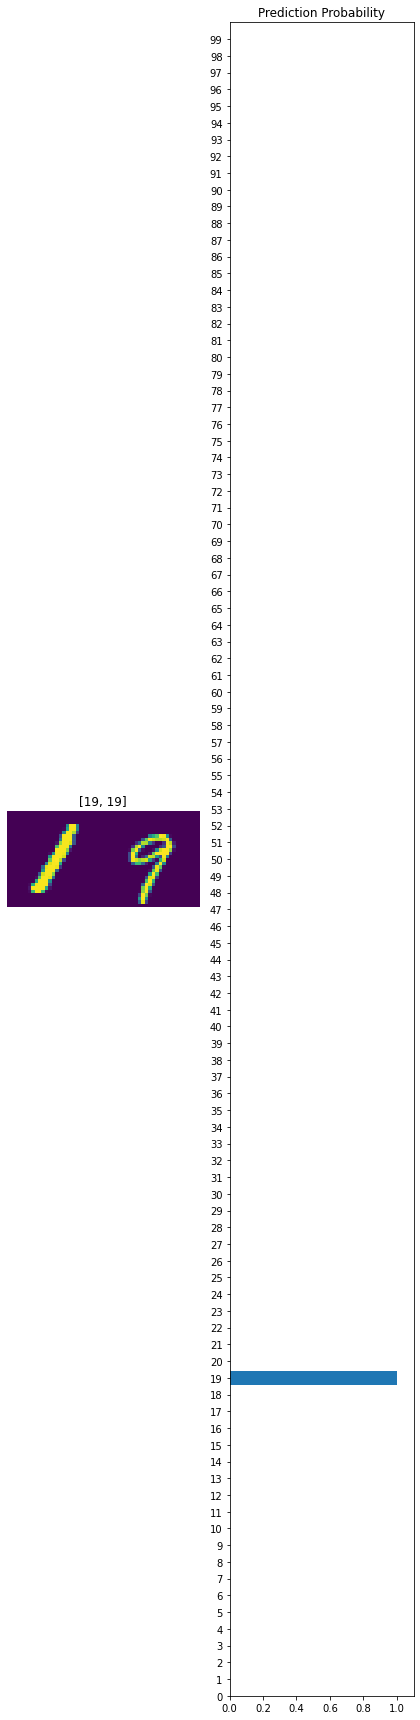

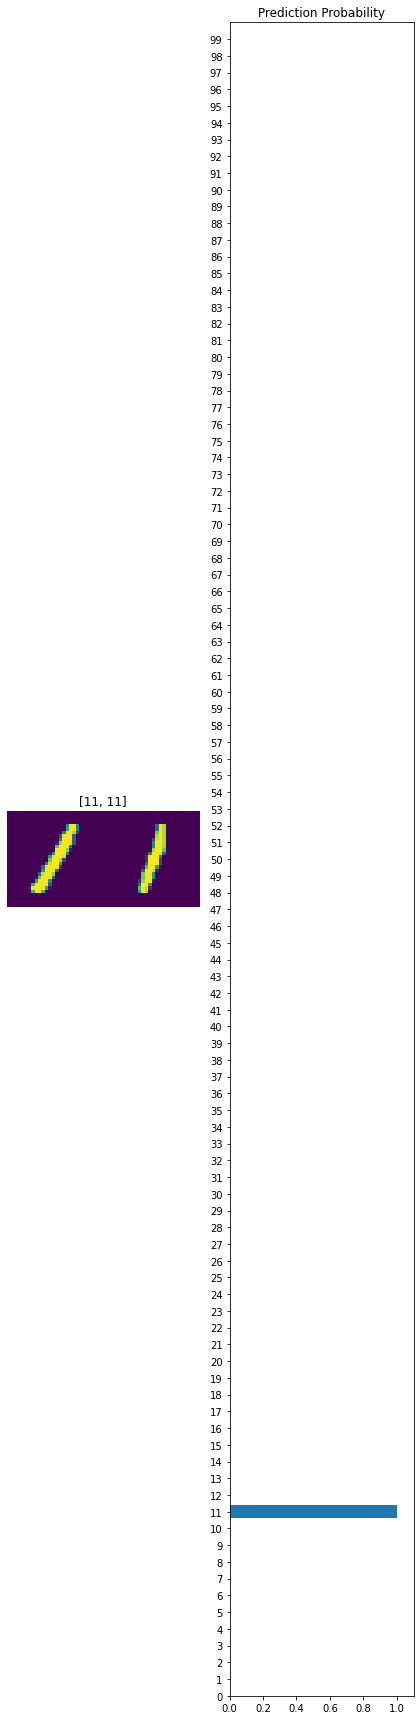

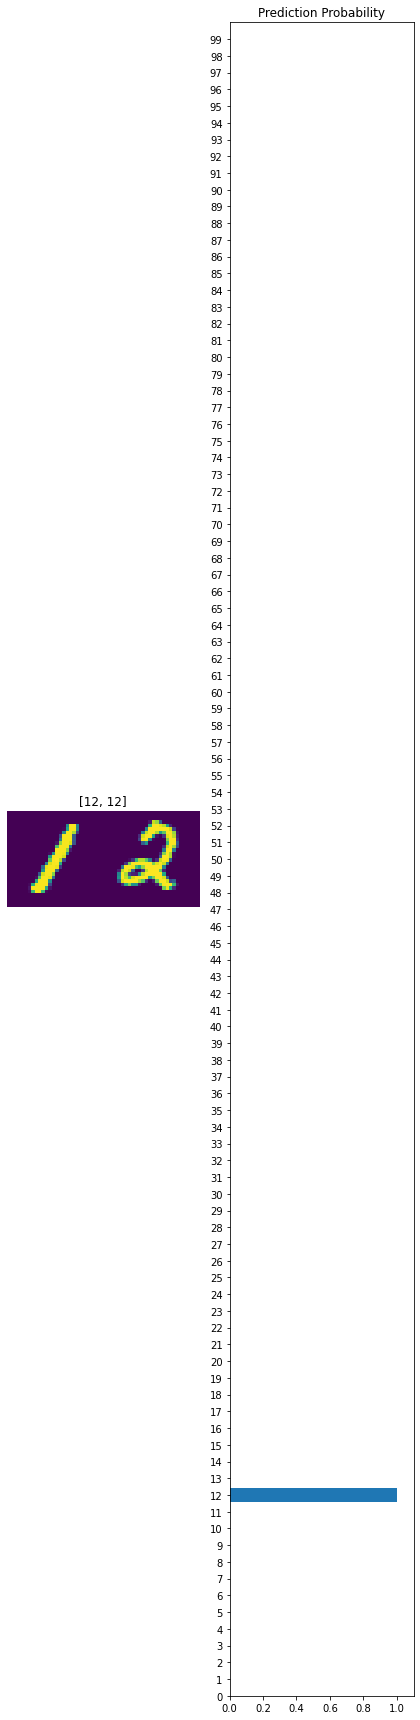

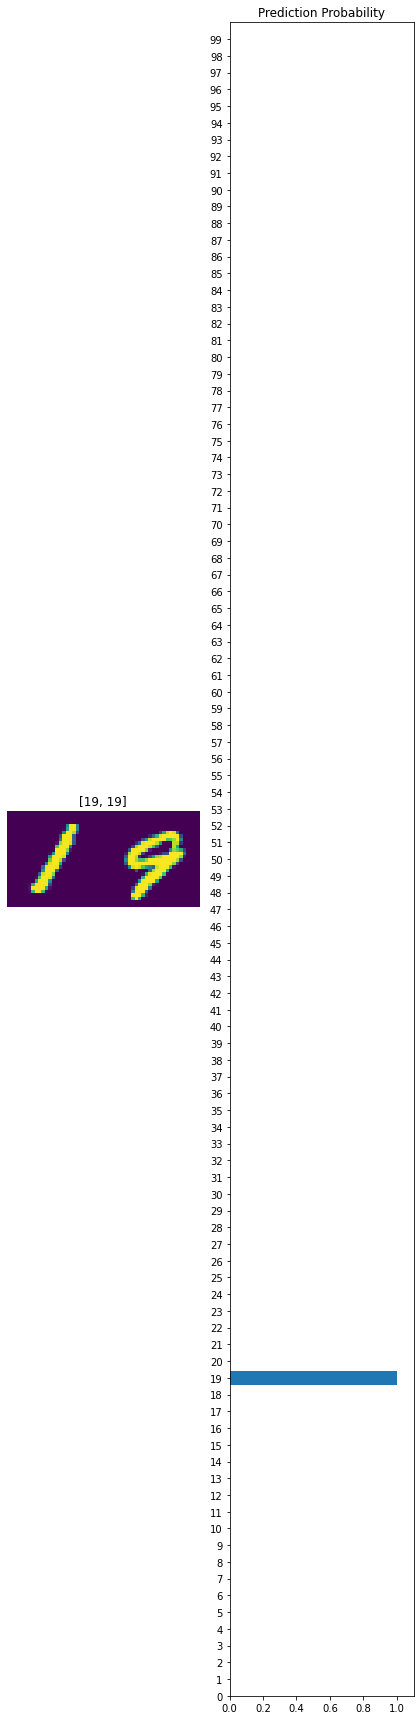

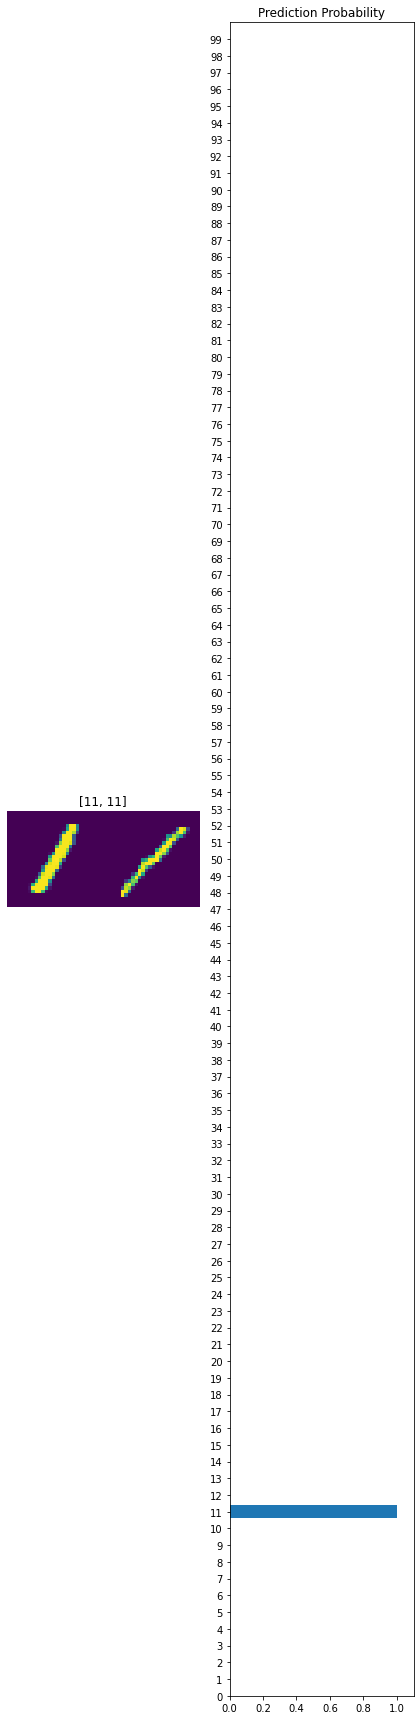

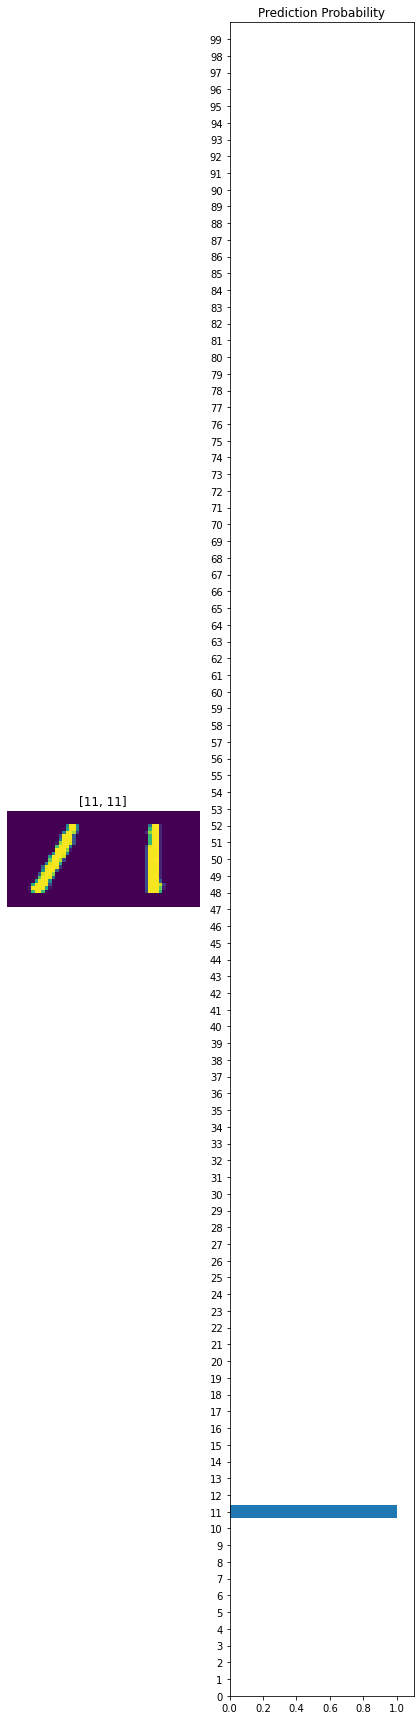

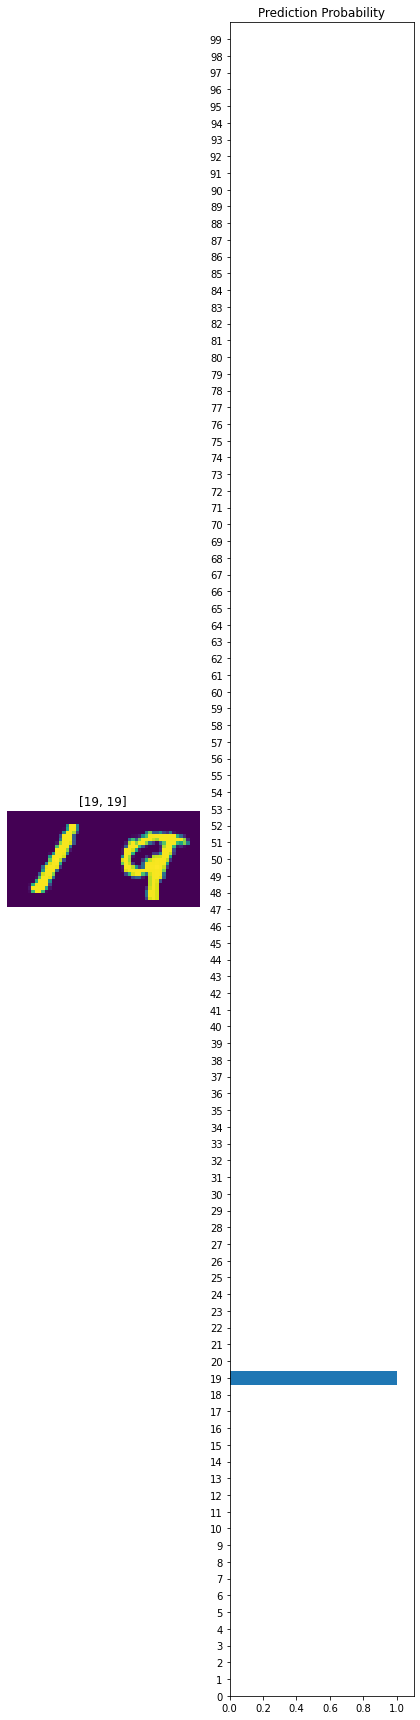

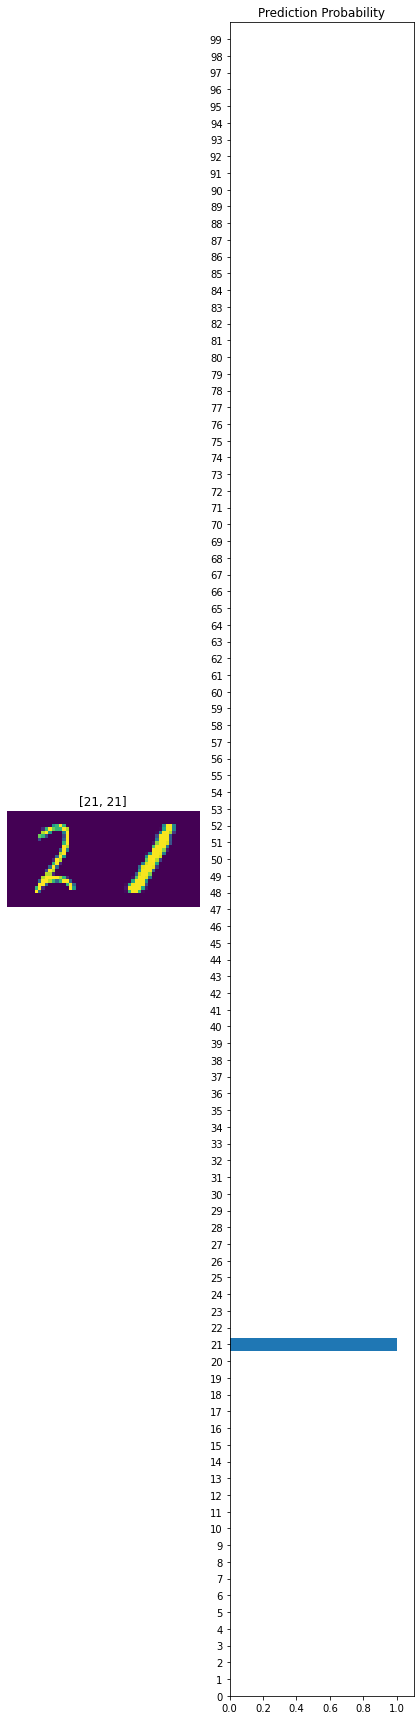

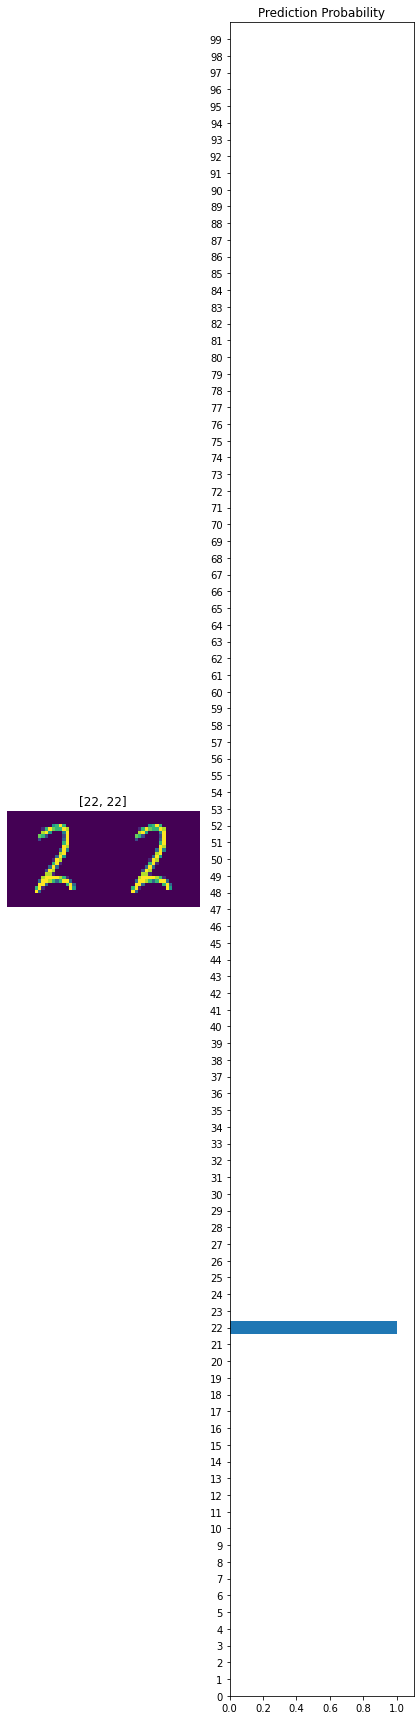

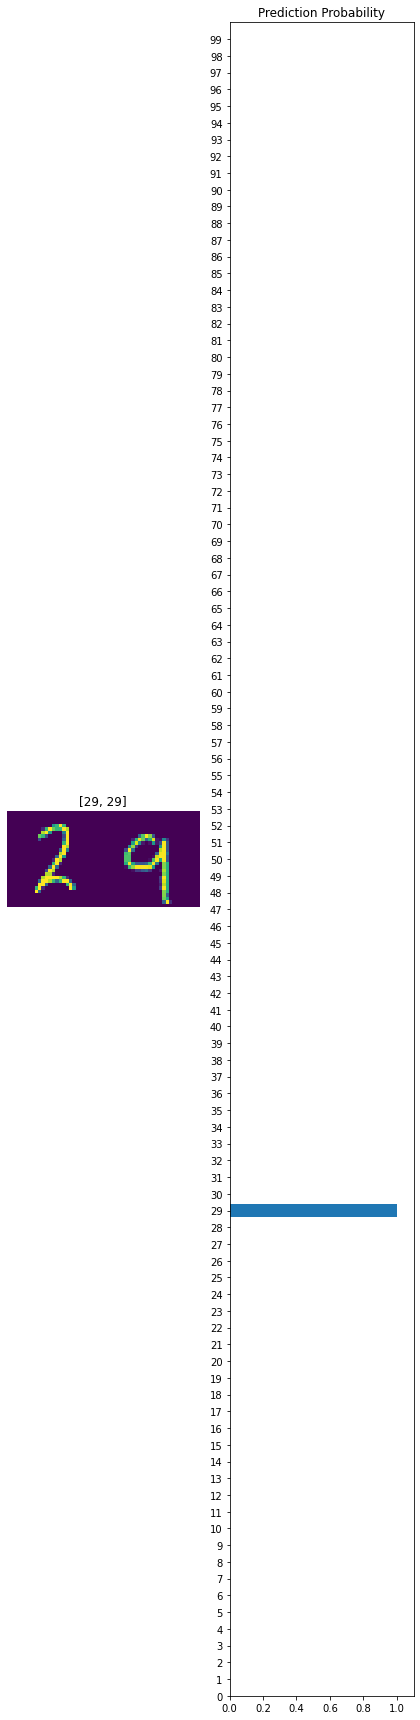

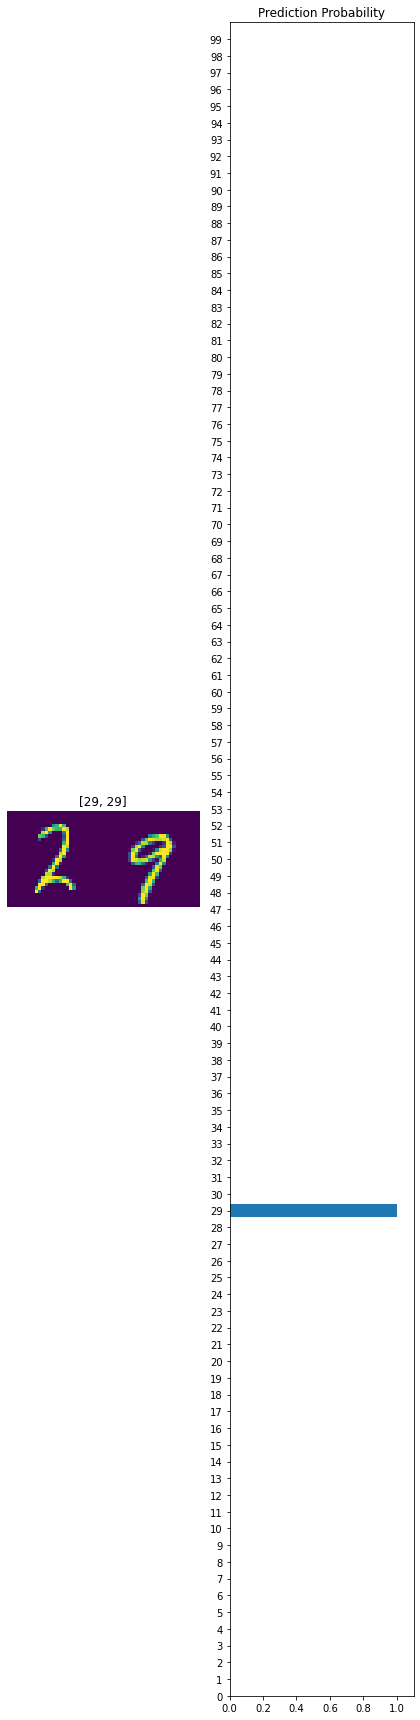

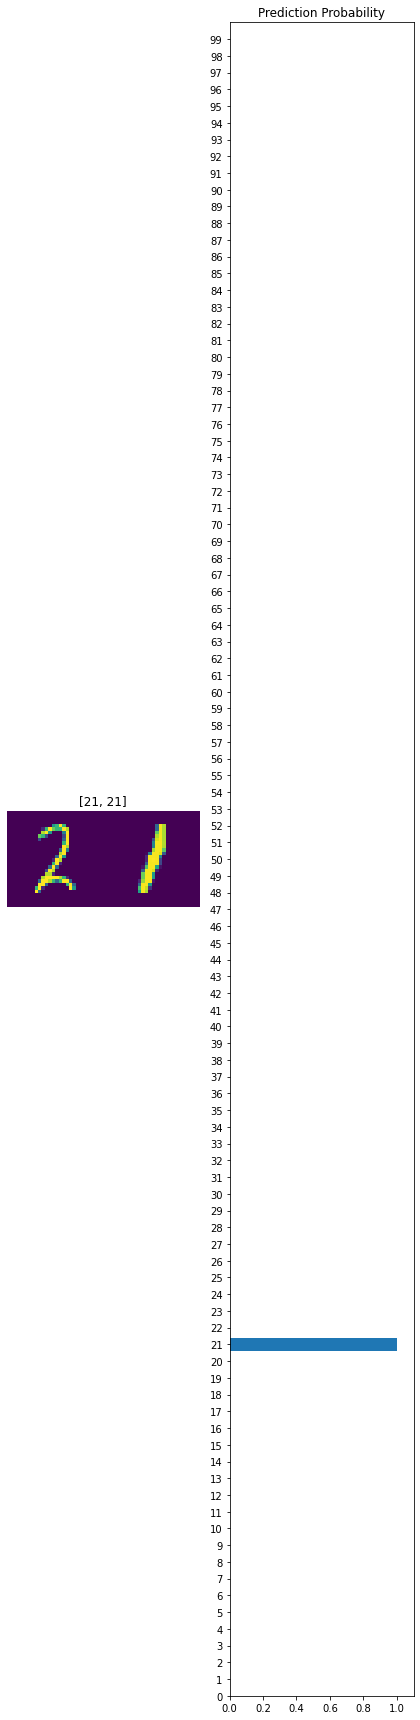

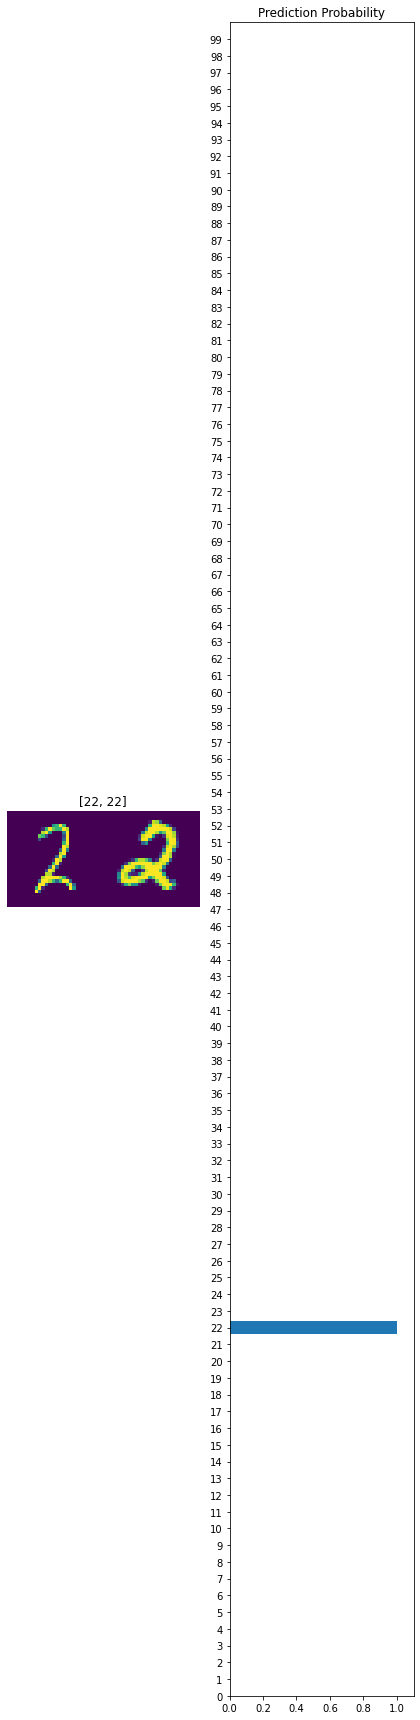

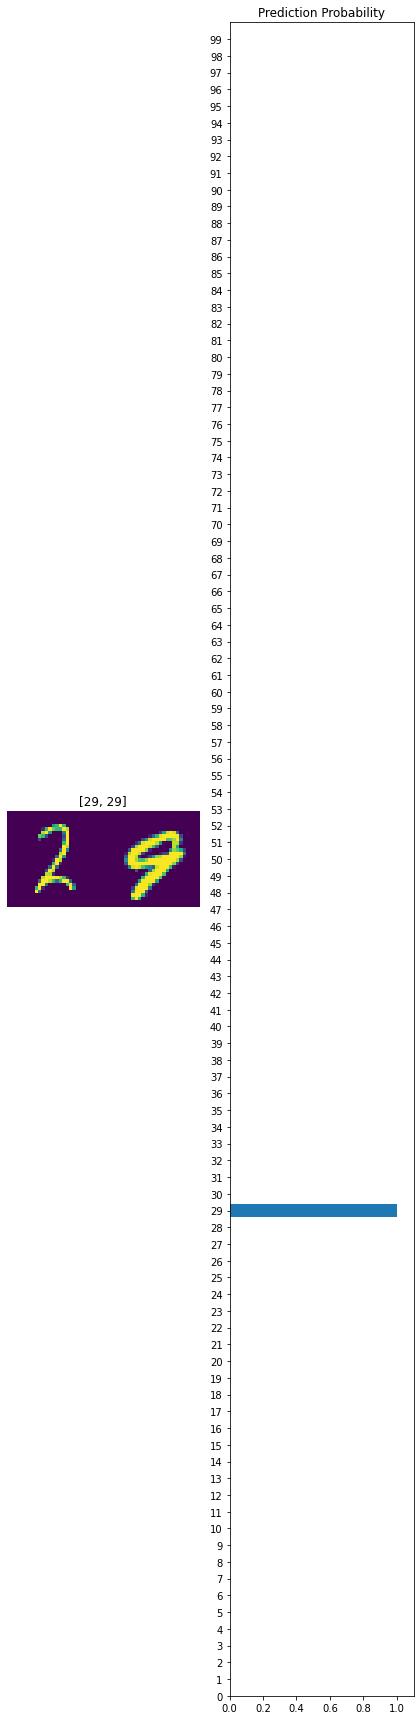

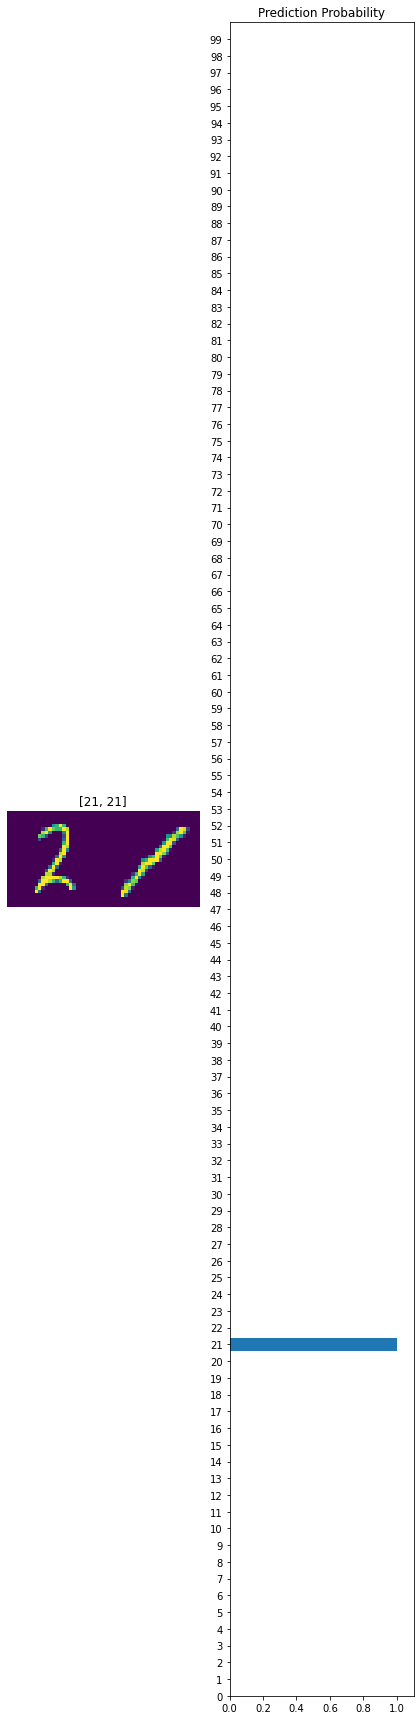

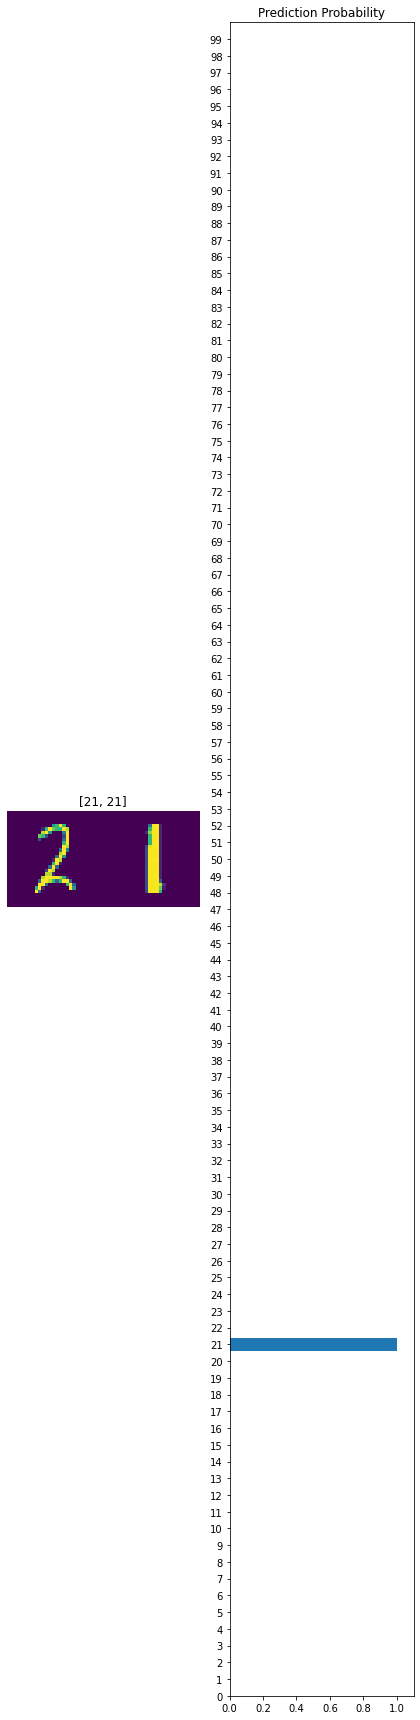

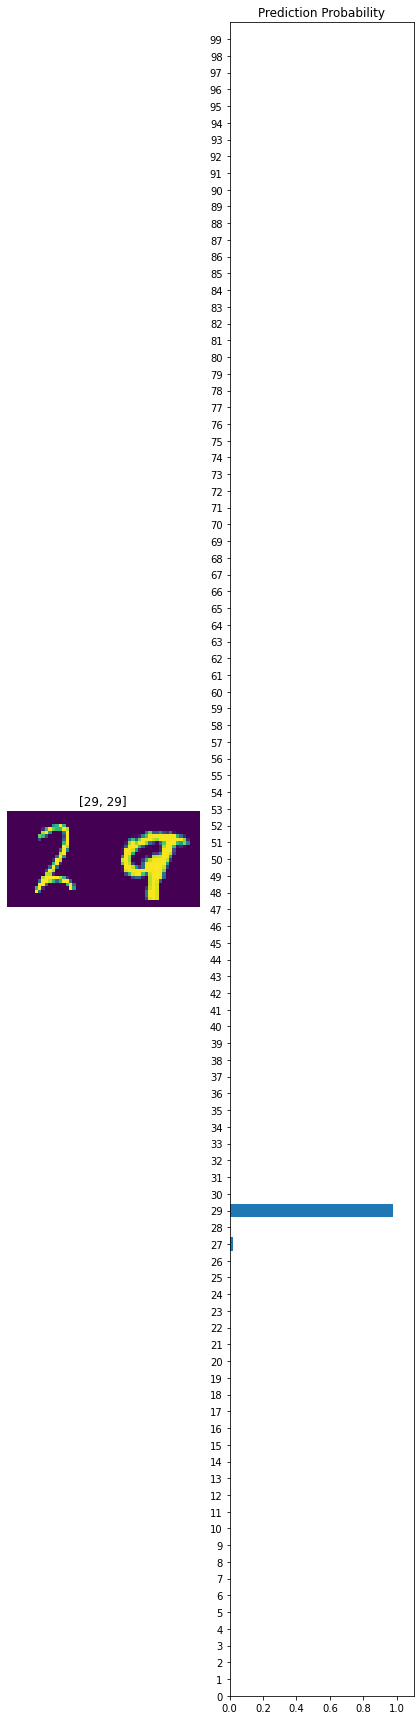

In [23]:
model_fnn.to('cpu') 

# fetch a batch of test images
image_batch, label_batch = next(iter(Test_data))

# Turn off gradients to speed up this part
with torch.no_grad():
    log_pred_prob_batch = model_fnn(image_batch)
for i in range(20):
    img = image_batch[i]
    real_label = label_batch[i].item()
    log_pred_prob = log_pred_prob_batch[i]
    # Output of the network are log-probabilities, need to take exponential for probabilities
    pred_prob = torch.exp(log_pred_prob).data.numpy().squeeze()
    visualize_pred(img, pred_prob, real_label)

## Network with Dropout

In [12]:
class FC2LayerDropout(nn.Module):
    def __init__(self, input_size, output_size):
        super(FC2LayerDropout, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, 400),
            nn.Dropout(0.2),
            nn.ReLU(), 
            nn.Linear(400, 400),
            nn.Dropout(0.2),
            nn.ReLU(), 
            nn.Linear(400,300),
            nn.ReLU(),
            nn.Linear(300, output_size), 
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)

In [13]:
print("With Dropout Training on ", device)
model_fnn = FC2LayerDropout(input_size, output_size)
model_fnn.to(device)
lr = 0.1
optimizer = optim.SGD(model_fnn.parameters(), lr=lr)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

hits = 0
epoch = 0
acc_init = 0

while hits < 5:
  model_fnn.train() # model_fnn in training mode. Turns on dropout, batch-norm etc during training
  train(epoch, model_fnn)
  model_fnn.eval() # model_fnn in evaluation mode. Turn off dropout, batch-norm etc during validation/testing
  epoch += 1
  acc = test(model_fnn)
  if acc < acc_init:
    hits += 1
    print("hit patience ",hits)
    print("hit #",hits," trial")
    print("load previously best model_fnn and decay learning rate to ",lr/2)
    lr = lr/2
    optimizer = optim.SGD(model_fnn.parameters(), lr=lr)
    model_fnn.train() # model_fnn in training mode. Turns on dropout, batch-norm etc during training
    train(epoch, model_fnn)
    model_fnn.eval() # model_fnn in evaluation mode. Turn off dropout, batch-norm etc during validation/testing
    epoch += 1
    acc = test(model_fnn)
  acc_init = acc

With Dropout Training on  cuda:0
Number of parameters: 938400
Train Epoch: 0 [0/600000 (0%)]	Loss: 4.620302
Train Epoch: 0 [10000/600000 (2%)]	Loss: 4.014650
Train Epoch: 0 [20000/600000 (3%)]	Loss: 2.869976
Train Epoch: 0 [30000/600000 (5%)]	Loss: 1.051123
Train Epoch: 0 [40000/600000 (7%)]	Loss: 1.161981
Train Epoch: 0 [50000/600000 (8%)]	Loss: 0.836419
Train Epoch: 0 [60000/600000 (10%)]	Loss: 1.527885
Train Epoch: 0 [70000/600000 (12%)]	Loss: 1.648956
Train Epoch: 0 [80000/600000 (13%)]	Loss: 0.779298
Train Epoch: 0 [90000/600000 (15%)]	Loss: 0.548670
Train Epoch: 0 [100000/600000 (17%)]	Loss: 0.616108
Train Epoch: 0 [110000/600000 (18%)]	Loss: 0.408099
Train Epoch: 0 [120000/600000 (20%)]	Loss: 0.261709
Train Epoch: 0 [130000/600000 (22%)]	Loss: 0.744057
Train Epoch: 0 [140000/600000 (23%)]	Loss: 0.616840
Train Epoch: 0 [150000/600000 (25%)]	Loss: 1.011618
Train Epoch: 0 [160000/600000 (27%)]	Loss: 1.931428
Train Epoch: 0 [170000/600000 (28%)]	Loss: 0.863994
Train Epoch: 0 [180000

So, using dropout, we are getting a little bit better accuracy.

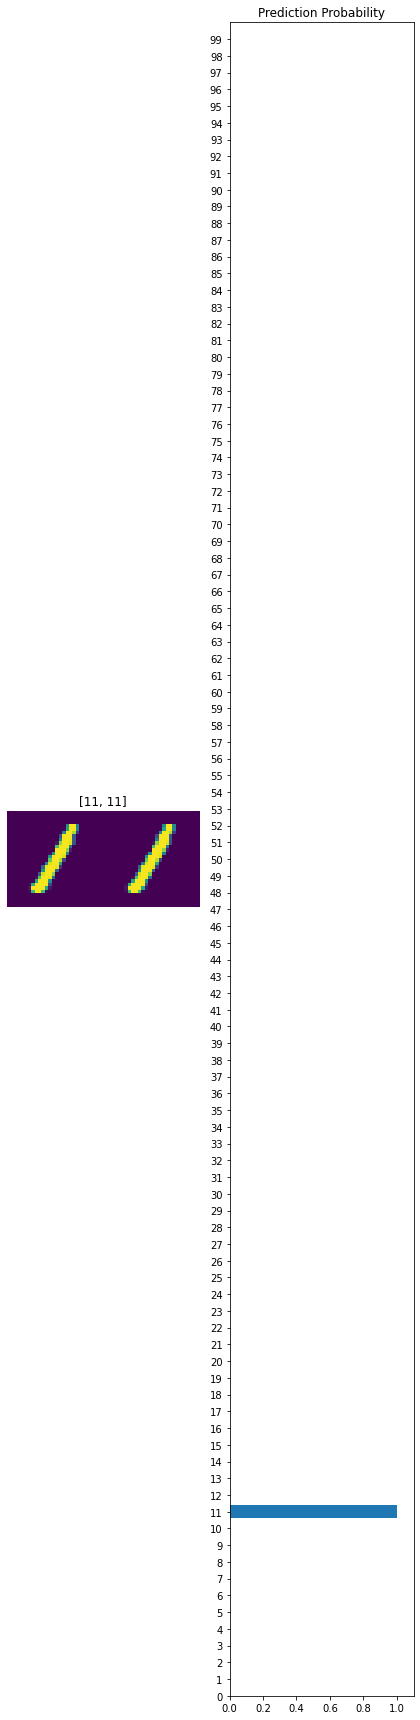

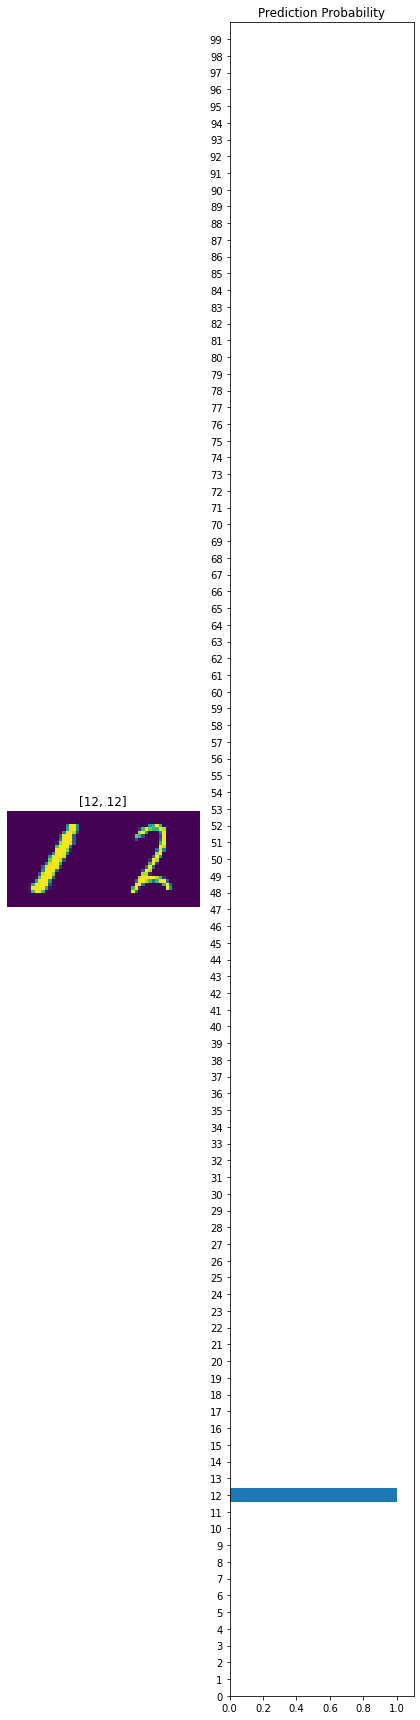

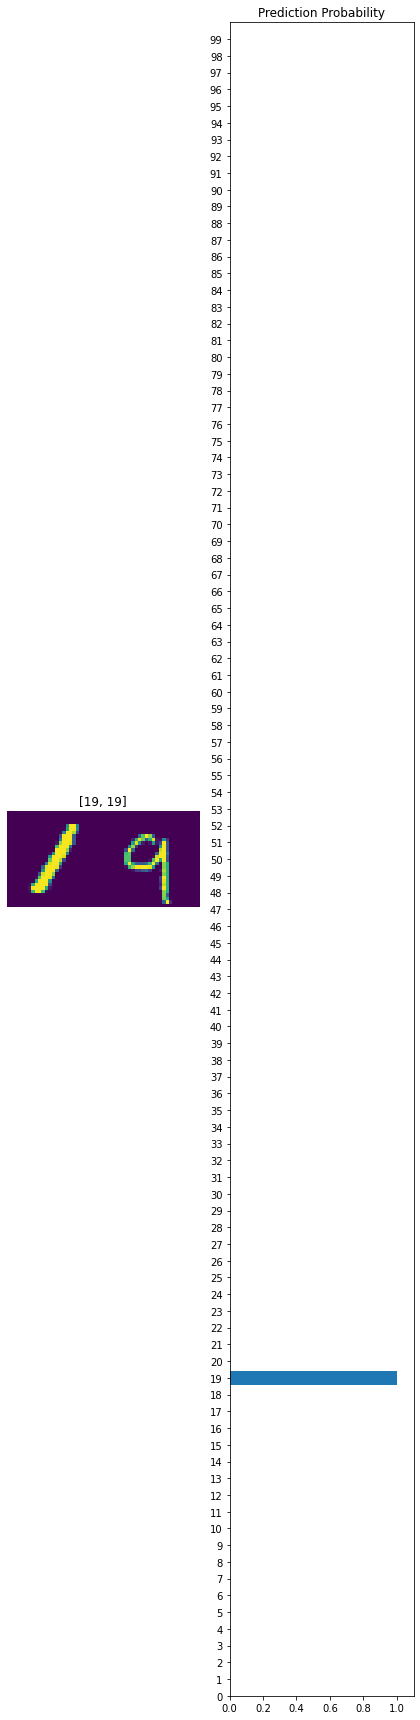

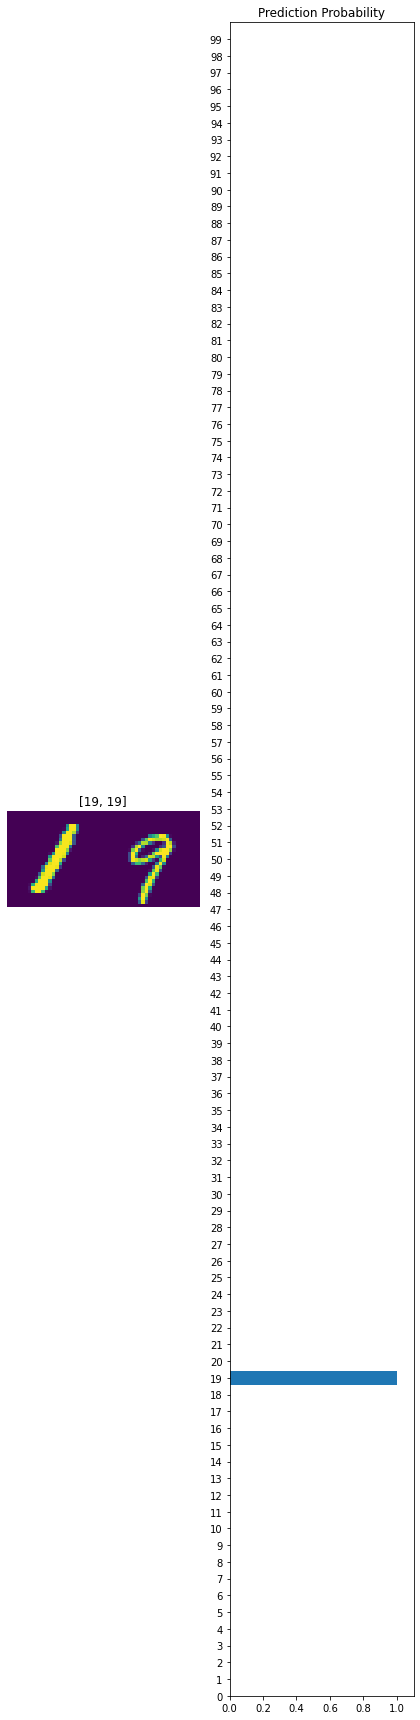

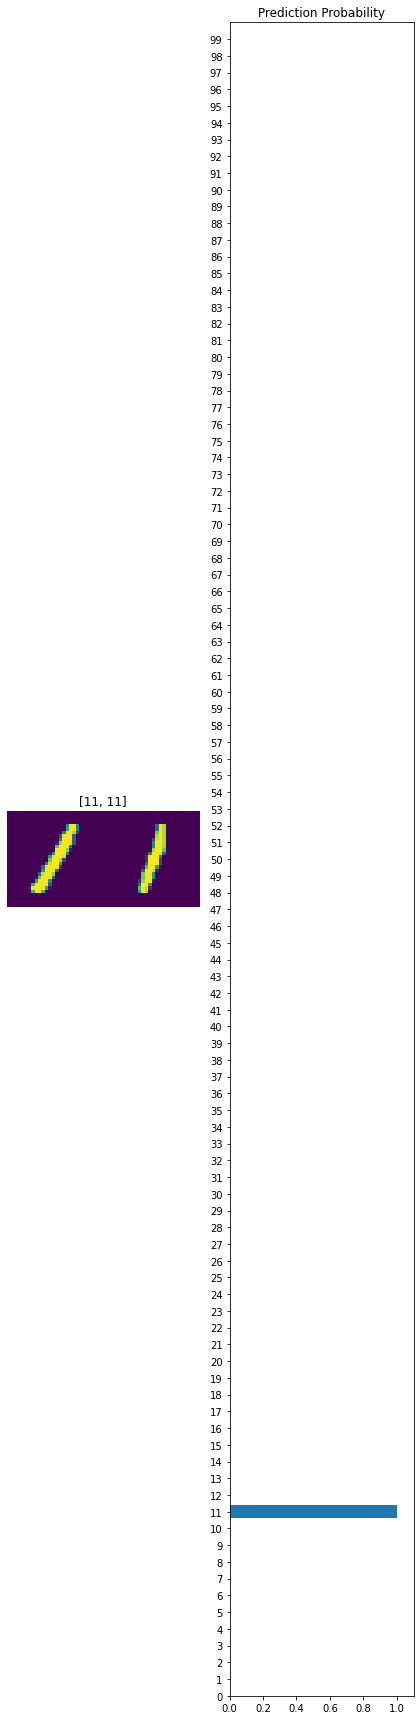

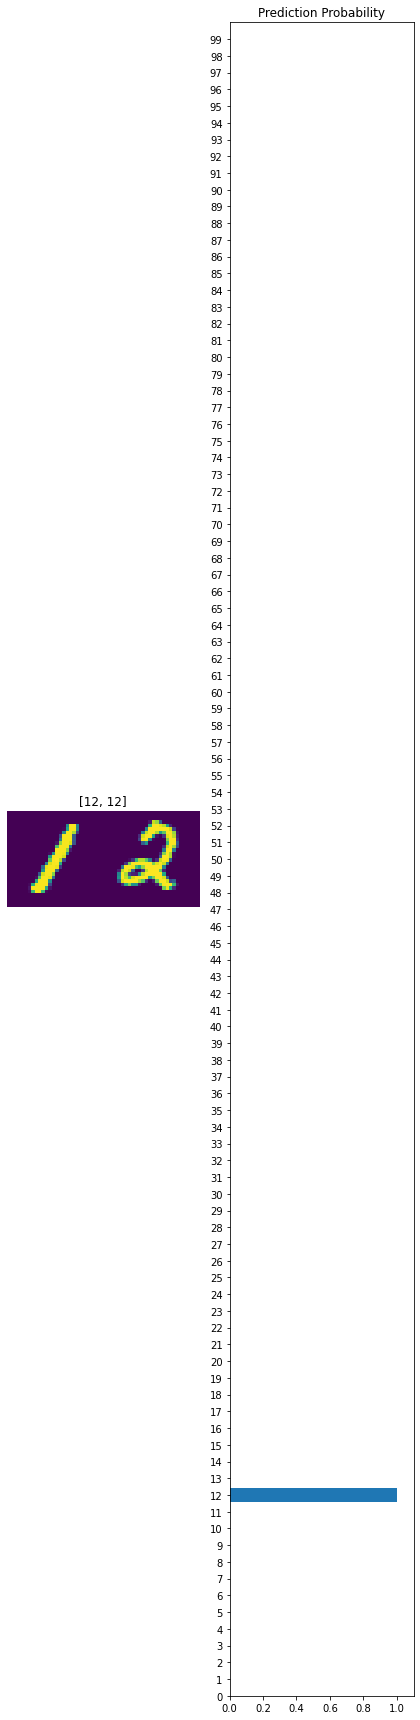

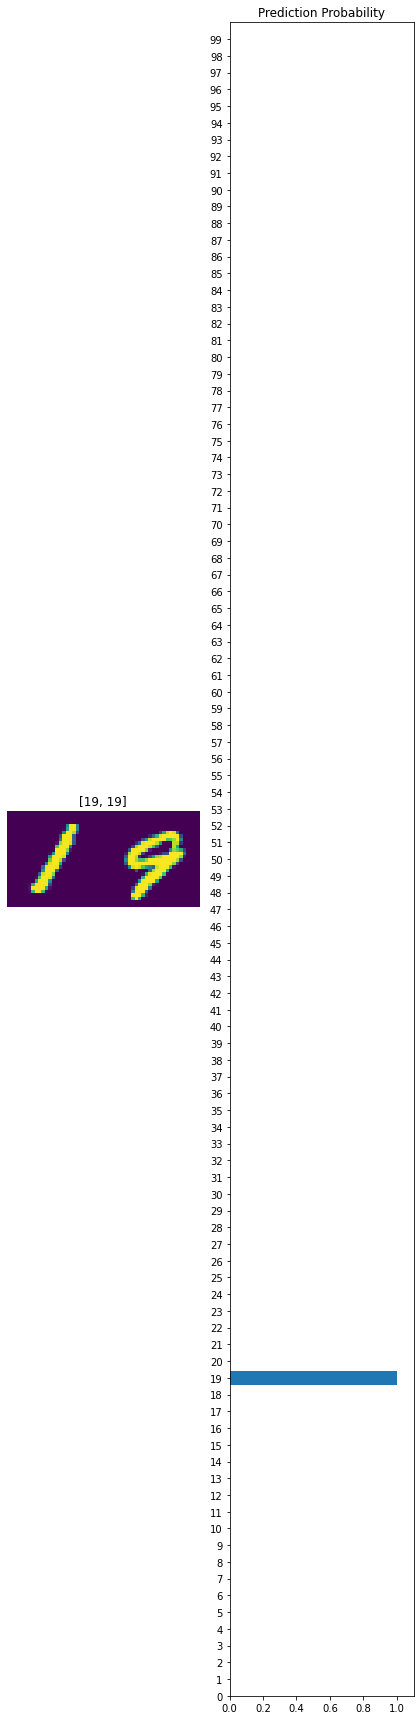

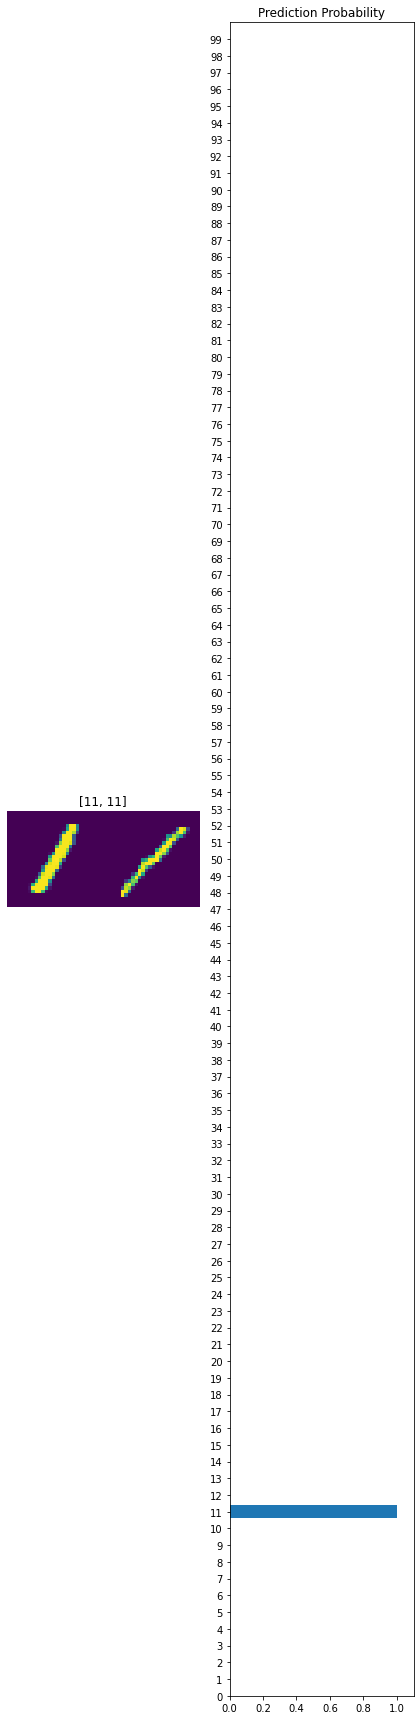

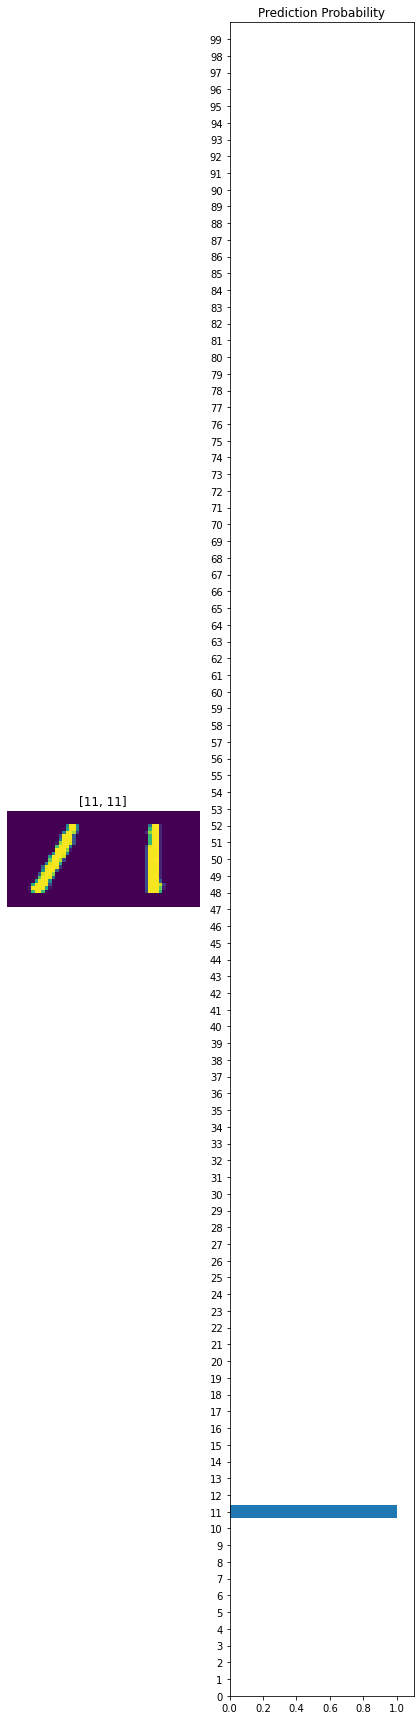

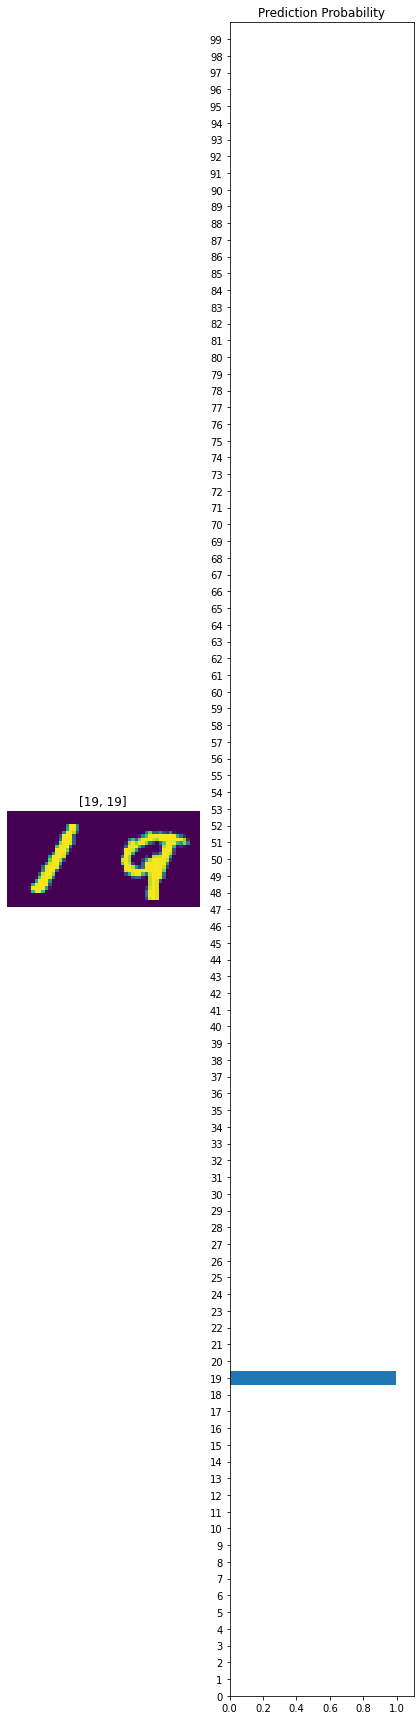

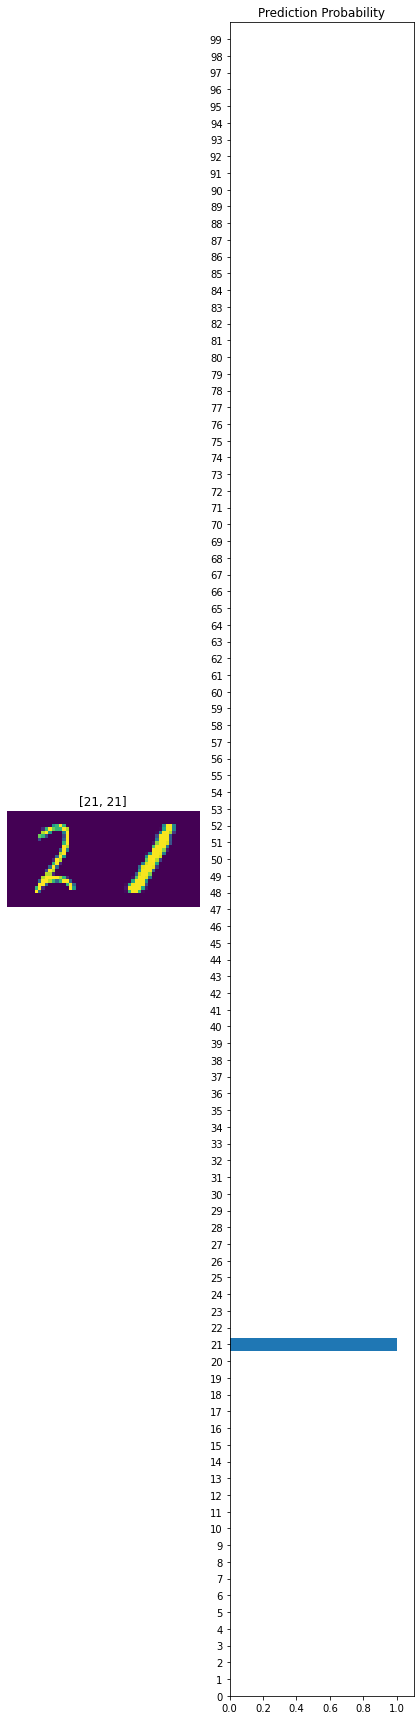

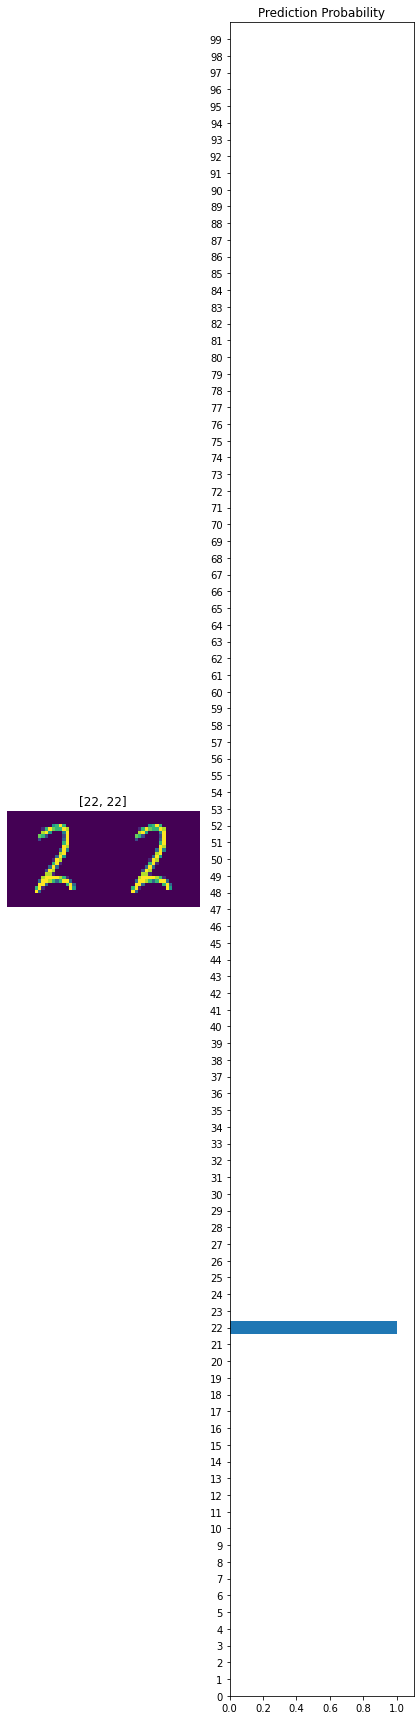

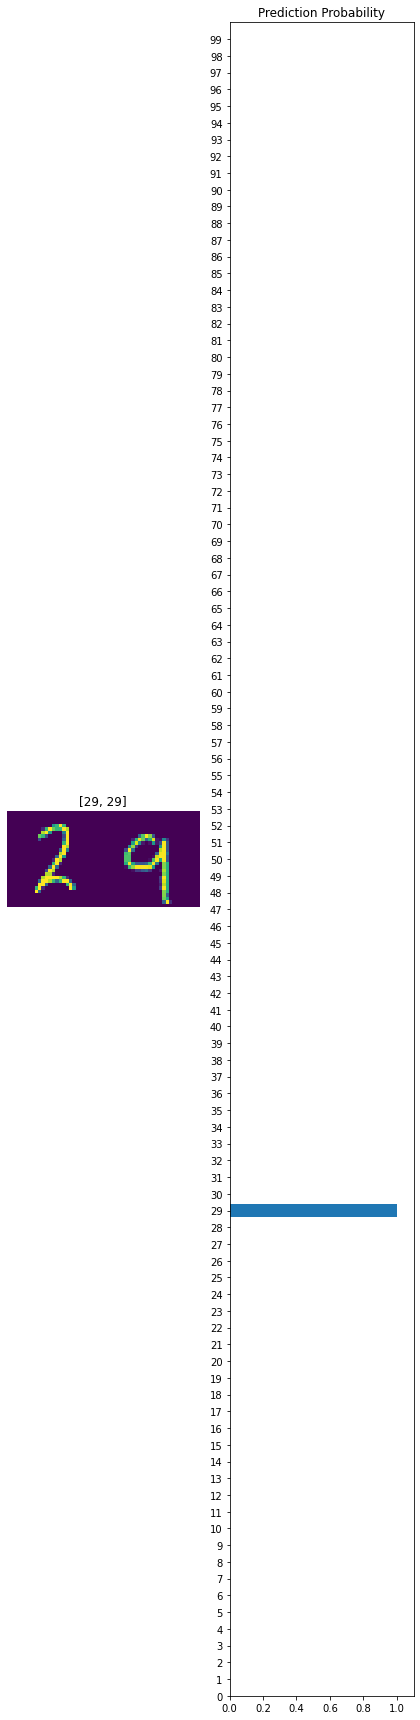

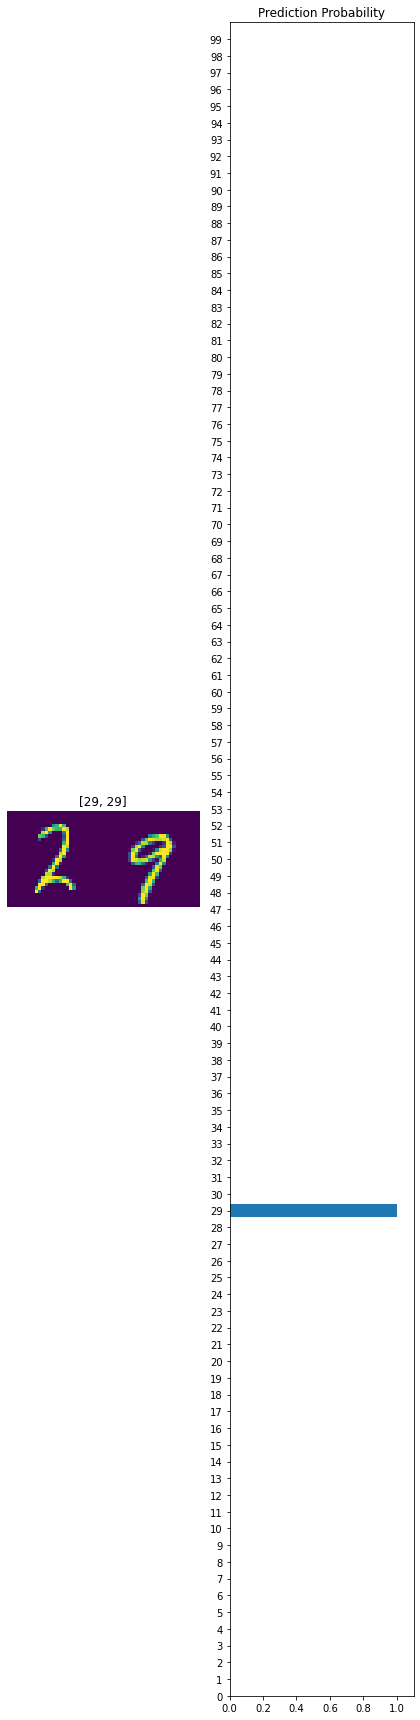

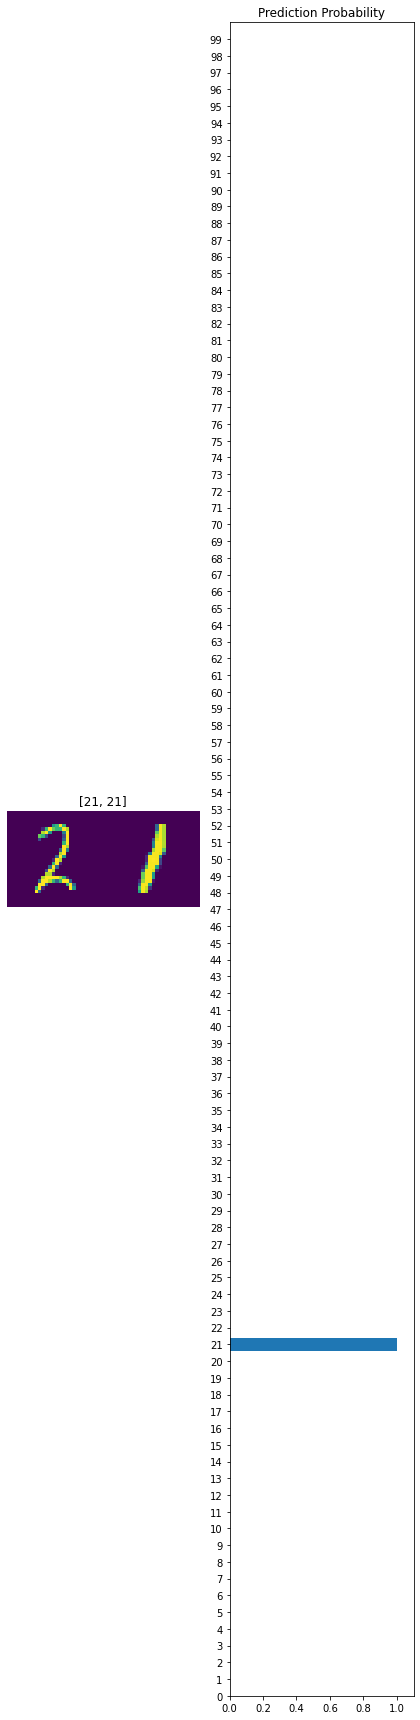

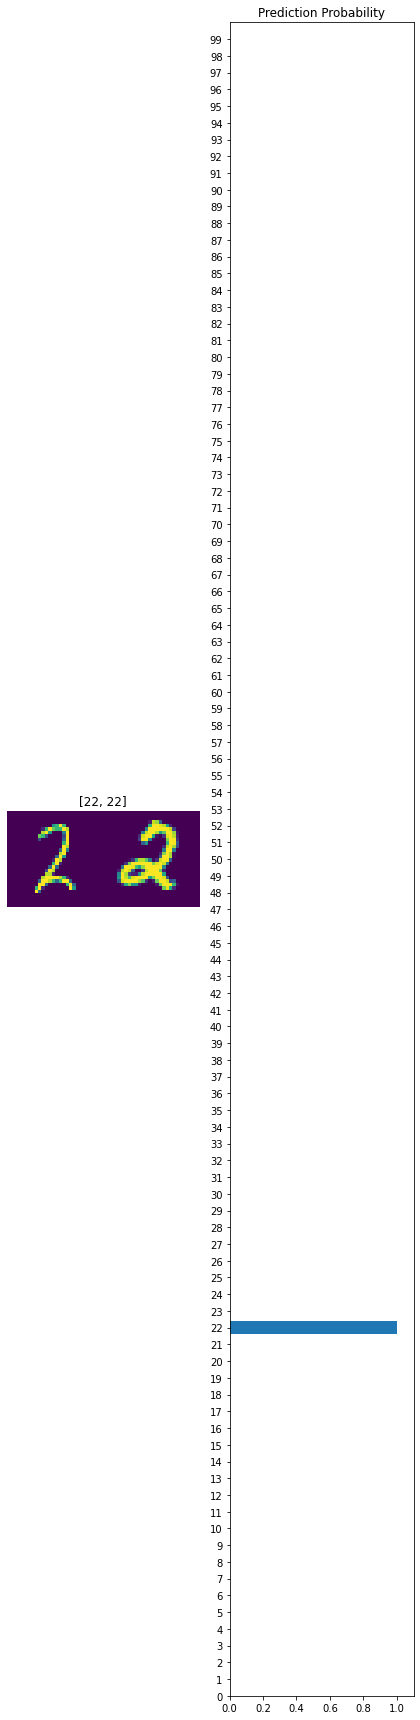

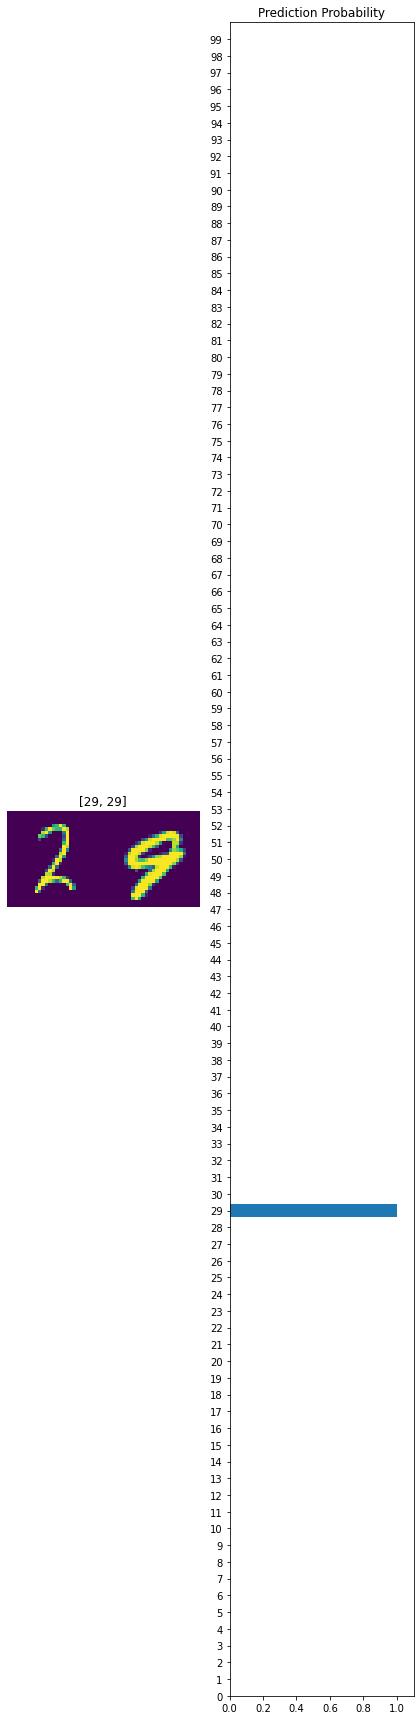

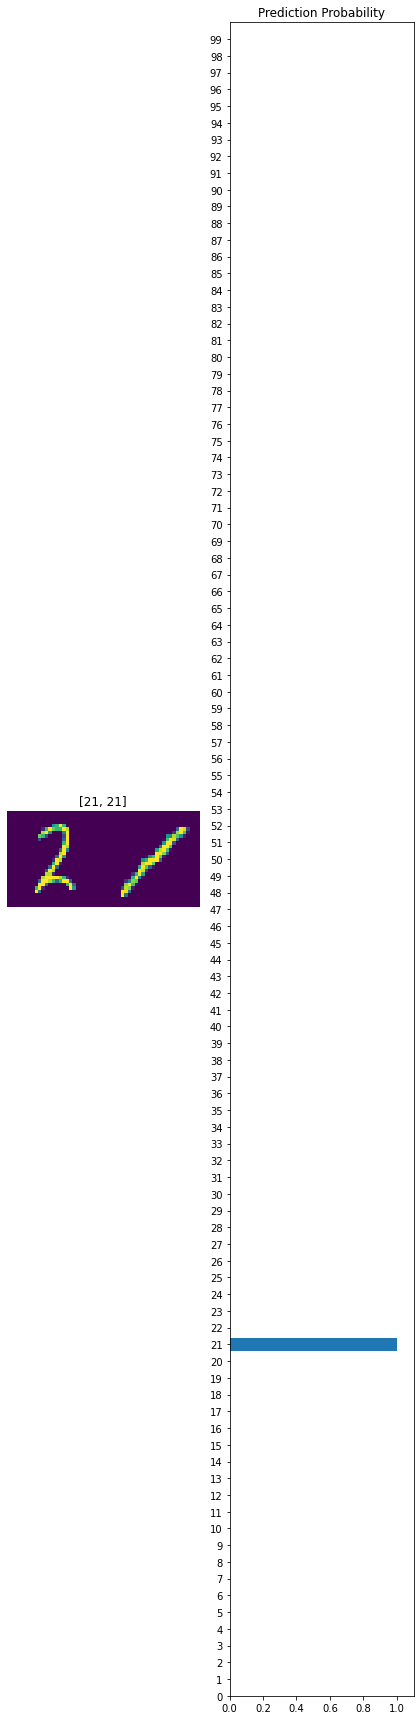

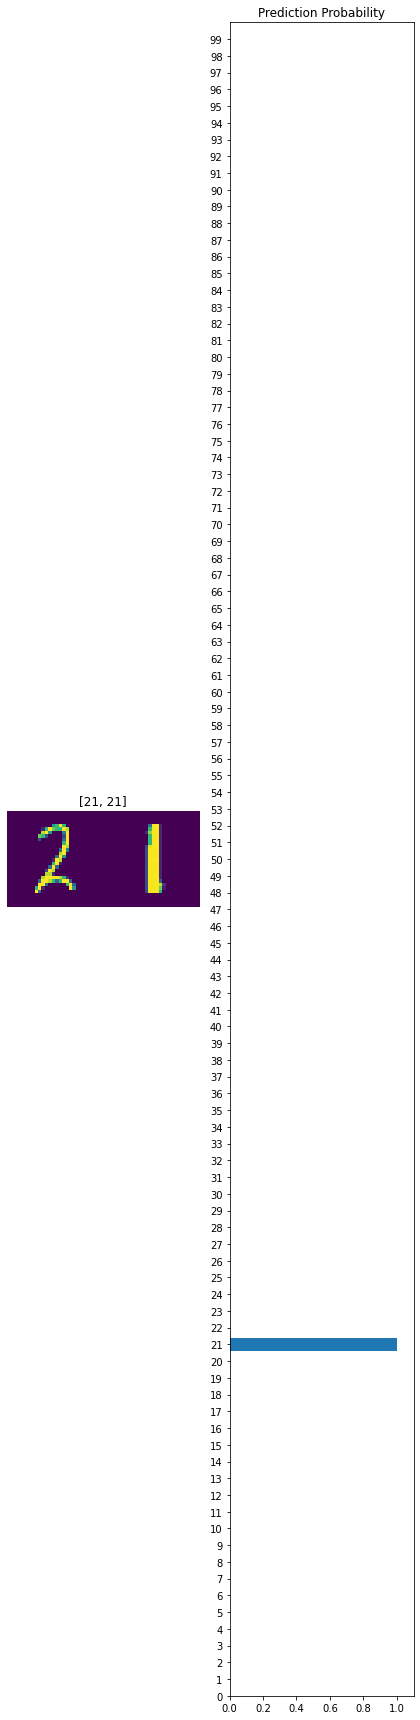

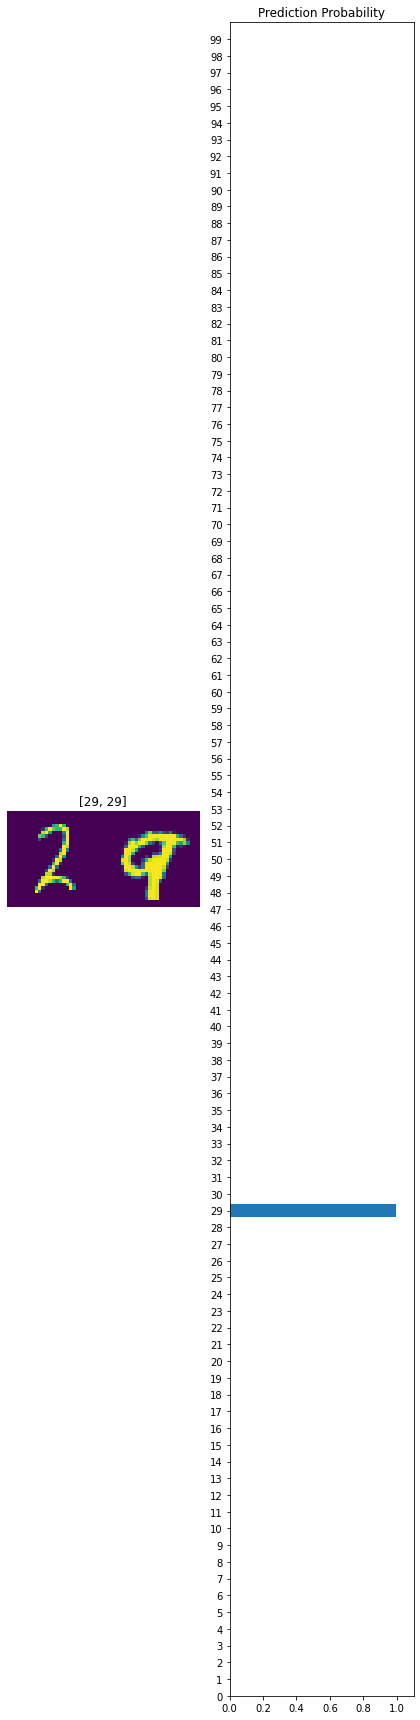

In [14]:
model_fnn.to('cpu') 

# fetch a batch of test images
image_batch, label_batch = next(iter(Test_data))

# Turn off gradients to speed up this part
with torch.no_grad():
    log_pred_prob_batch = model_fnn(image_batch)
for i in range(20):
    img = image_batch[i]
    real_label = label_batch[i].item()
    log_pred_prob = log_pred_prob_batch[i]
    # Output of the network are log-probabilities, need to take exponential for probabilities
    pred_prob = torch.exp(log_pred_prob).data.numpy().squeeze()
    visualize_pred(img, pred_prob, real_label)